--2019-09-07 17:47:04--  https://www.dropbox.com/s/15fjap17rxajqai/OGZPY.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/15fjap17rxajqai/OGZPY.csv [following]
--2019-09-07 17:47:05--  https://www.dropbox.com/s/raw/15fjap17rxajqai/OGZPY.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5c882013fb5f7736d754c03bec.dl.dropboxusercontent.com/cd/0/inline/AoEMVB0OZJN8YBYBhjKuHbIkPNLvmrgvEQ-9_PLjmxiFrwFn0XJNZ6Ckl2_VEMLMttDP8-8CePgvheRI2l2Snlbw1zknF4bs2u5gnQvQVkUhuohnv-5RuarVUuiy_tlj-xk/file# [following]
--2019-09-07 17:47:05--  https://uc5c882013fb5f7736d754c03bec.dl.dropboxusercontent.com/cd/0/inline/AoEMVB0OZJN8YBYBhjKuHbIkPNLvmrgvEQ-9_PLjmxiFrwFn0XJNZ6Ckl2_VEMLMttDP8-8CePgvheRI2l2Snlbw1zknF4bs2u5gnQvQVkUhuohnv-5

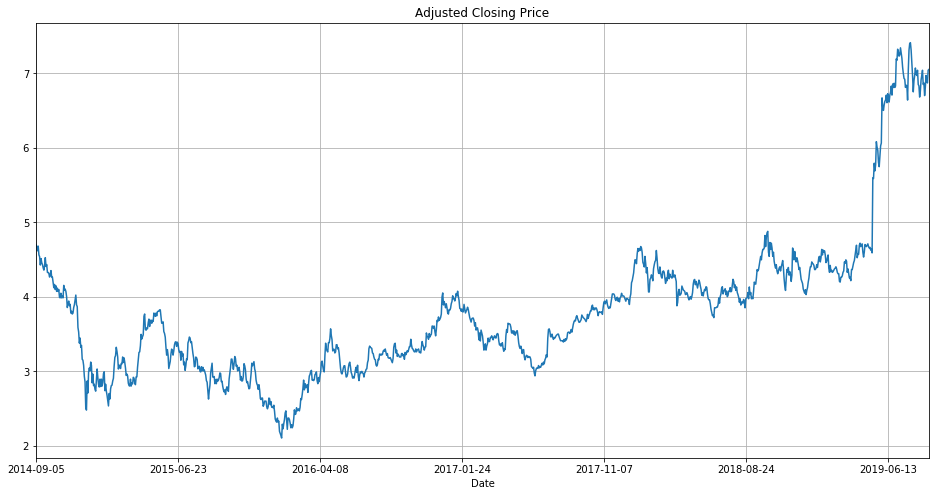

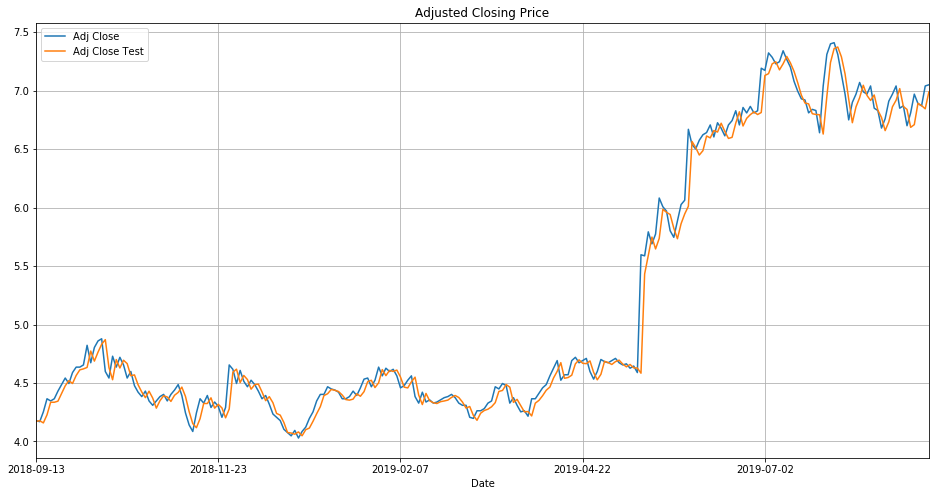

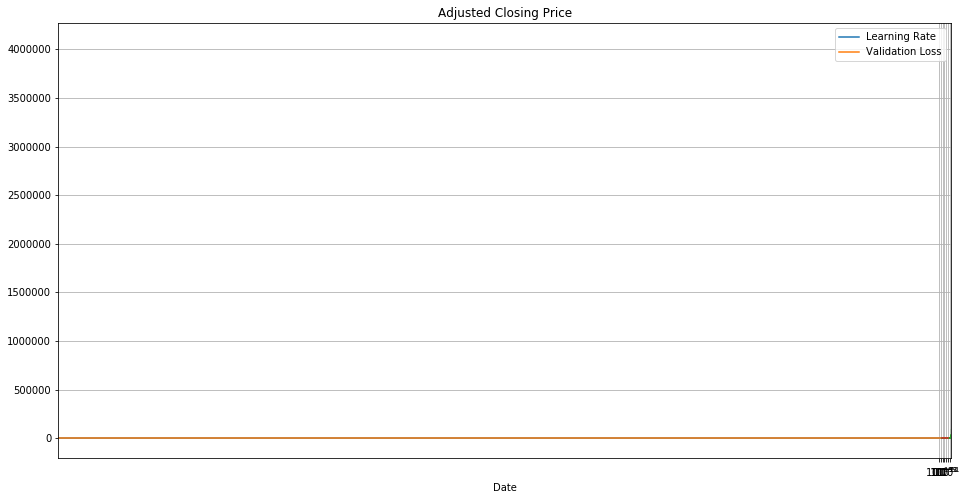

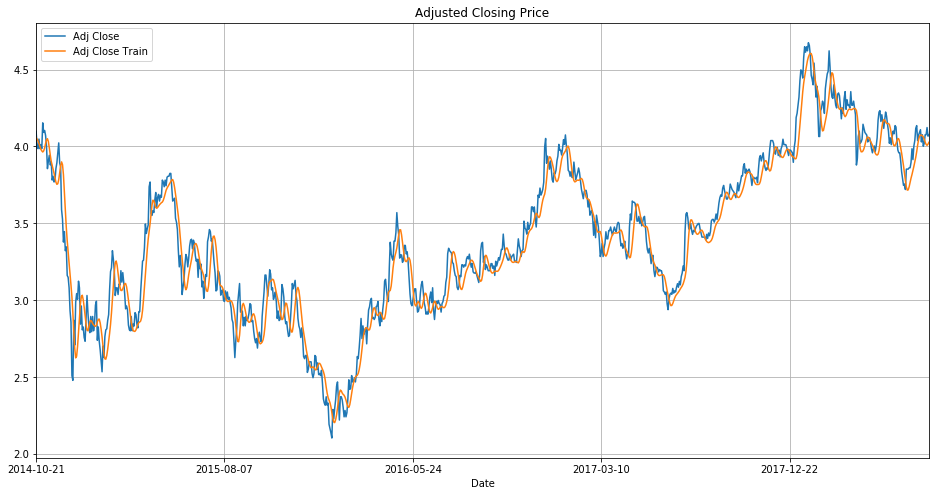

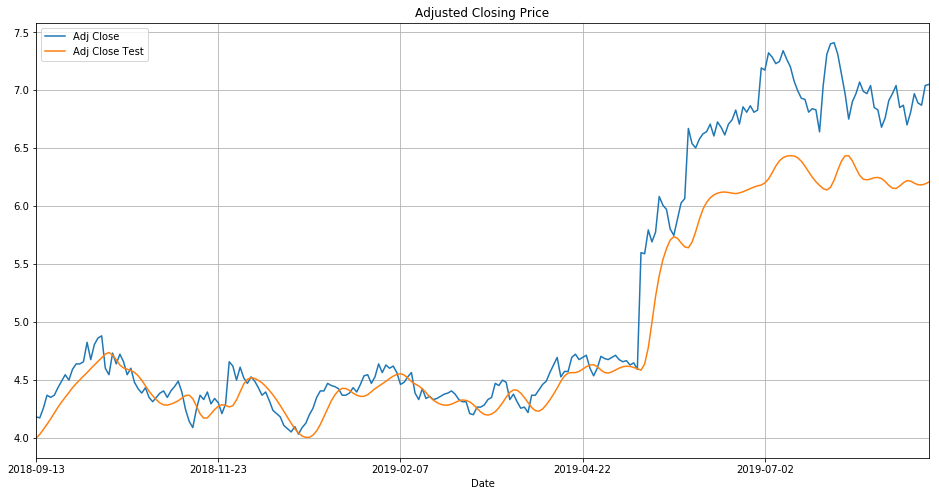

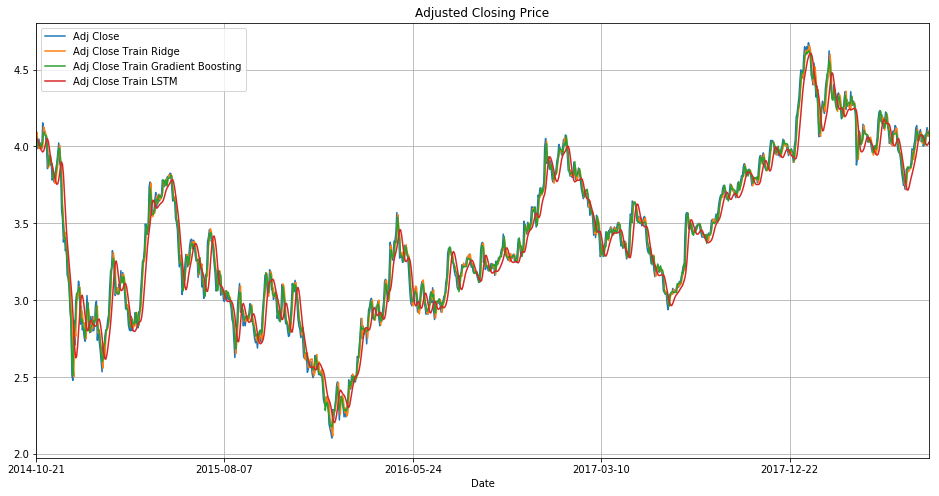

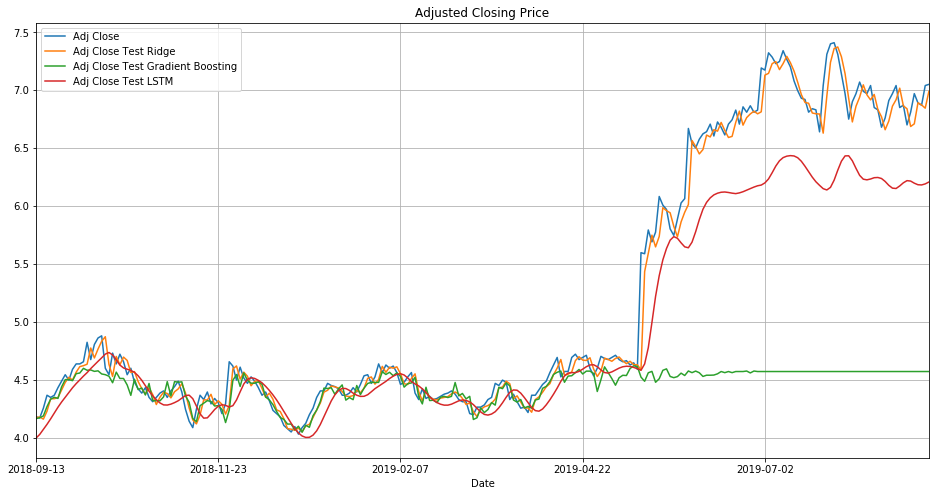

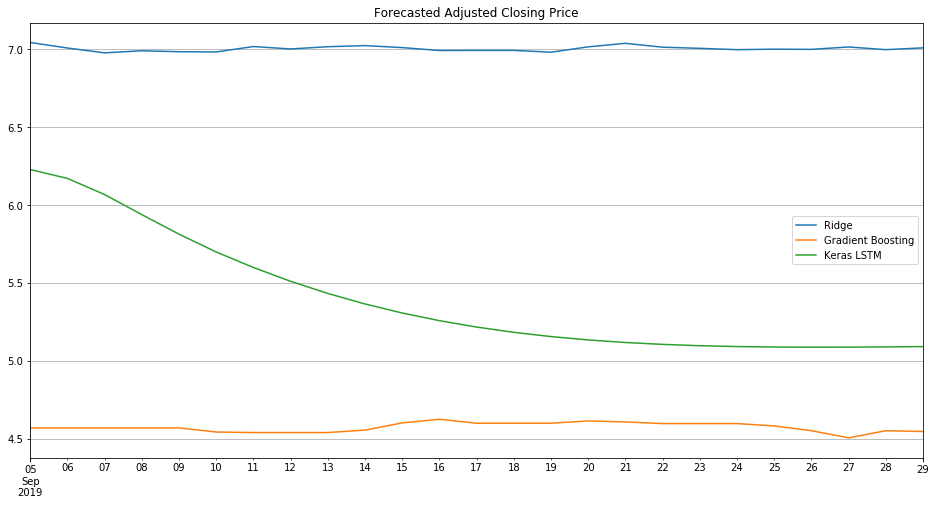

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

!wget -O OGZPY.csv https://www.dropbox.com/s/15fjap17rxajqai/OGZPY.csv?dl=0

df = pd.read_csv('OGZPY.csv')
df.set_index('Date', inplace=True)
df.head()

df['Adj Close'].plot(label='OGZPY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

window_size = 32
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

data = df['Adj Close'].values[indices]

X = data[:,:-1]
y = data[:,-1]

split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)


df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='OGZPY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='OGZPY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='OGPZY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='OGPZY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='OGPZY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='OGZPY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

num_days = 25 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]

from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='OGZPY', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)